# Neologism Learning: LIMA Data Exploration
## Project: Do Neologisms Transfer Across Language Models?

**Goal**: Load and explore the LIMA dataset, then sample data for training the ~short neologism.

**Authors**: Owen Terry, Varun Ramamurthi, Sungjoon Park  
**Concept**: ~short (responses under 50 words)

**Last edited: 12.2.2025**

In [1]:
!pip install datasets transformers torch accelerate huggingface_hub matplotlib seaborn pandas numpy

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\varun\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset
from typing import List, Dict, Tuple
from collections import Counter
from huggingface_hub import login

# Set style for plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

c:\Users\varun\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
HF_TOKEN = ""  # Varun's HF authentication
login(token=HF_TOKEN)

In [4]:
# returns the raw dataset
lima_dataset = load_dataset("GAIR/lima", split="train", revision="refs/convert/parquet")

In [5]:
# Print first two examples
for i in range(2):
    example = lima_dataset[i]
    conversations = example['conversations']
    
    print(f"\n{'='*80}")
    print(f"EXAMPLE {i+1}")
    print(f"{'='*80}")
    
    # First turn is the instruction/question
    print(f"\n[QUESTION]")
    print(f"{conversations[0]}")
    
    # Second turn is the response/answer
    if len(conversations) > 1:
        print(f"\n[ANSWER]")
        print(f"{conversations[1]}")
    
    # Additional metadata
    print(f"\n[METADATA]")
    print(f"Number of conversation turns: {len(conversations)}")
    print(f"Response character count: {len(conversations[1]) if len(conversations) > 1 else 0}")
    print(f"Response word count: {len(conversations[1].split()) if len(conversations) > 1 else 0}")


EXAMPLE 1

[QUESTION]
Can brain cells move? By movement I mean long distance migration (preferably within the brain only).

[ANSWER]
The question is relatively broad and one should take into account that the brain not only consists of neurons, but also glial cells (supportive cells) and pre-mitotic neuronal stem cells. Furthermore, as critical fellow-scientists have indicated, developmental stage is very important, as the developing embryonic brain is very different from the adult brain.
However, after sifting through various publications, the answer to the question is actually remarkably simple: Yes, brain cells migrate.
In  the adult brain glial cells migrate in the brain (Klämbt, 2009). Glial cells are involved in a myriad of functions, but a notable example of migrating glial cells are the oligodendrocytes that migrate relative long distances to find their target axons onto which they wrap themselves to form the insulating myelin sheath (Tsai and Miller, 2002).
Neuronal stem cells

### Calculate Basic Statistics on Answer Lengths

Analyze the length distribution of responses (conversations[1]) across the entire dataset.

In [6]:
def calculate_length_statistics(dataset):
    """
    Calculate comprehensive length statistics for LIMA responses.
    Returns char lengths, word counts, and statistics dictionary.
    """
    char_lengths = []
    word_counts = []
    
    for example in dataset:
        conversations = example['conversations']
        # Get the response (second turn)
        if len(conversations) > 1:
            response = conversations[1]
            char_lengths.append(len(response))
            word_counts.append(len(response.split()))
    
    stats = {
        'total_examples': len(char_lengths),
        'char_mean': np.mean(char_lengths),
        'char_median': np.median(char_lengths),
        'char_std': np.std(char_lengths),
        'char_min': np.min(char_lengths),
        'char_max': np.max(char_lengths),
        'char_25th': np.percentile(char_lengths, 25),
        'char_75th': np.percentile(char_lengths, 75),
        'word_mean': np.mean(word_counts),
        'word_median': np.median(word_counts),
        'word_std': np.std(word_counts),
        'word_min': np.min(word_counts),
        'word_max': np.max(word_counts),
        'word_25th': np.percentile(word_counts, 25),
        'word_75th': np.percentile(word_counts, 75),
    }
    
    return char_lengths, word_counts, stats

# Calculate statistics
all_char_lengths, all_word_counts, all_stats = calculate_length_statistics(lima_dataset)

print(f"\n{'='*80}")
print("LIMA RESPONSE LENGTH STATISTICS")
print(f"{'='*80}")
print(f"\nTotal responses analyzed: {all_stats['total_examples']:,}")

print(f"\n{'─'*80}")
print("CHARACTER-BASED STATISTICS")
print(f"{'─'*80}")
print(f"  Mean:      {all_stats['char_mean']:.1f} characters")
print(f"  Median:    {all_stats['char_median']:.1f} characters")
print(f"  Std Dev:   {all_stats['char_std']:.1f} characters")
print(f"  Min:       {all_stats['char_min']} characters")
print(f"  Max:       {all_stats['char_max']:,} characters")
print(f"  25th %ile: {all_stats['char_25th']:.1f} characters")
print(f"  75th %ile: {all_stats['char_75th']:.1f} characters")

print(f"\n{'─'*80}")
print("WORD-BASED STATISTICS")
print(f"{'─'*80}")
print(f"  Mean:      {all_stats['word_mean']:.1f} words")
print(f"  Median:    {all_stats['word_median']:.1f} words")
print(f"  Std Dev:   {all_stats['word_std']:.1f} words")
print(f"  Min:       {all_stats['word_min']} words")
print(f"  Max:       {all_stats['word_max']:,} words")
print(f"  25th %ile: {all_stats['word_25th']:.1f} words")
print(f"  75th %ile: {all_stats['word_75th']:.1f} words")


LIMA RESPONSE LENGTH STATISTICS

Total responses analyzed: 1,030

────────────────────────────────────────────────────────────────────────────────
CHARACTER-BASED STATISTICS
────────────────────────────────────────────────────────────────────────────────
  Mean:      2523.5 characters
  Median:    1562.0 characters
  Std Dev:   2755.2 characters
  Min:       15 characters
  Max:       17,742 characters
  25th %ile: 995.8 characters
  75th %ile: 2644.8 characters

────────────────────────────────────────────────────────────────────────────────
WORD-BASED STATISTICS
────────────────────────────────────────────────────────────────────────────────
  Mean:      437.0 words
  Median:    263.0 words
  Std Dev:   492.4 words
  Min:       1 words
  Max:       3,090 words
  25th %ile: 162.2 words
  75th %ile: 442.0 words


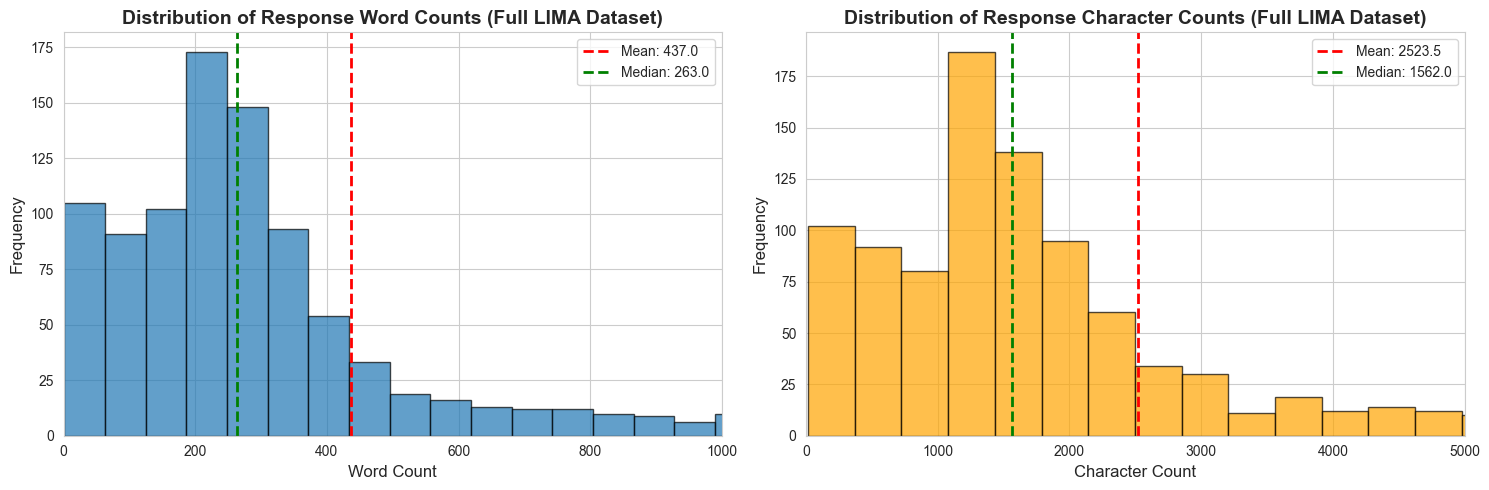

In [7]:
# Visualize distributions
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Word count distribution
axes[0].hist(all_word_counts, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(all_stats['word_mean'], color='red', linestyle='--', linewidth=2, label=f"Mean: {all_stats['word_mean']:.1f}")
axes[0].axvline(all_stats['word_median'], color='green', linestyle='--', linewidth=2, label=f"Median: {all_stats['word_median']:.1f}")
axes[0].set_xlabel('Word Count', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Response Word Counts (Full LIMA Dataset)', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].set_xlim(0, 1000)  # Focus on main distribution

# Character count distribution
axes[1].hist(all_char_lengths, bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].axvline(all_stats['char_mean'], color='red', linestyle='--', linewidth=2, label=f"Mean: {all_stats['char_mean']:.1f}")
axes[1].axvline(all_stats['char_median'], color='green', linestyle='--', linewidth=2, label=f"Median: {all_stats['char_median']:.1f}")
axes[1].set_xlabel('Character Count', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Distribution of Response Character Counts (Full LIMA Dataset)', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].set_xlim(0, 5000)  # We'll zoom in later

plt.tight_layout()
plt.show()

In [10]:
#OpenAI installs
!pip install openai

import openai
from openai import OpenAI
import time
from tqdm import tqdm  # For progress bar


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\varun\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable


In [ ]:
# graciously contributed by Sungjoon
OPENAI_API_KEY = ""

# Initialize OpenAI client
client = OpenAI(api_key=OPENAI_API_KEY)

In [12]:
#y_c
def generate_short_response(instruction, max_words=50):
    prompt = f"Answer the question concisely in under {max_words} words: {instruction}"
    
    try:
        # Call GPT-4o-mini
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "user", "content": prompt}
            ],
            temperature=0.9,  # bias toward quality
            max_tokens=100,   # Limit output length
        )
        
        # Extract the generated text
        generated_text = response.choices[0].message.content.strip()
        return generated_text
        
    except Exception as e:
        print(f"Error generating response: {e}")
        return None

# For testing
test_instruction = lima_dataset[0]['conversations'][0]
test_response = generate_short_response(test_instruction)
print(f"\nInstruction: {test_instruction[:200]}")
print(f"\nGenerated short response: {test_response}")
print(f"\nWord count: {len(test_response.split())} words")


Instruction: Can brain cells move? By movement I mean long distance migration (preferably within the brain only).

Generated short response: Yes, certain brain cells, such as neuroblasts, can migrate long distances during development and postnatally, particularly in regions like the olfactory bulb and hippocampus. However, fully mature neurons typically do not migrate long distances.

Word count: 34 words


In [13]:
#y_r
def generate_long_response(instruction, min_words=400, max_words=450):
    prompt = f"""Answer the following question in extensive detail. Do not stop generating until you have outputted a response between {min_words} and {max_words} words. Be thorough, provide context, examples, and elaborate on all relevant points: {instruction}"""
    
    try:
        # Call GPT-4o-mini
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "user", "content": prompt}
            ],
            temperature=0.7,  # Slightly lower for more coherent long-form content
            max_tokens=2000,  # Allow enough tokens for long response
        )
        
        # Extract the generated text
        generated_text = response.choices[0].message.content.strip()
        
        return generated_text
        
    except Exception as e:
        print(f"Error generating response: {e}")
        return None

# For testing
test_instruction = lima_dataset[0]['conversations'][0]
test_response = generate_long_response(test_instruction)
print(f"\nInstruction: {test_instruction[:200]}")
print(f"\nGenerated long response: {test_response[:300]}...")  # Show first 300 chars
print(f"\nWord count: {len(test_response.split())} words")


Instruction: Can brain cells move? By movement I mean long distance migration (preferably within the brain only).

Generated long response: The question of whether brain cells, specifically neurons and glial cells, can move or migrate within the brain is a fascinating one that touches on the dynamic nature of the brain’s architecture and functionality. While the traditional view of the brain depicts it as a relatively static organ, newe...

Word count: 473 words


## The below step costs $ to generate tokens

Generation loop for remaining 930 examples, after the first 100 were generated.

In [14]:
import json
import os

# --- Configuration ---
INPUT_FILE = 'first_100.jsonl' # The file you already generated
TARGET_TOTAL = 1030
CHECKPOINT_INTERVAL = 200 # Save every 200 new examples

# --- Helper Function ---
def save_jsonl(filename, data):
    """Writes a list of dictionaries to a JSONL file."""
    with open(filename, 'w') as f:
        for item in data:
            f.write(json.dumps(item) + '\n')

# --- 1. Load Existing Work ---
all_data = []
try:
    if os.path.exists(INPUT_FILE):
        with open(INPUT_FILE, 'r') as f:
            for line in f:
                if line.strip():
                    all_data.append(json.loads(line))
        print(f"✅ Successfully loaded {len(all_data)} existing examples.")
    else:
        print(f"⚠️ Input file '{INPUT_FILE}' not found. Starting from scratch.")
except Exception as e:
    print(f"❌ Error loading file: {e}")

# --- 2. Processing Loop ---
failed_count = 0
start_index = len(all_data)
batch_buffer = [] # temporary storage for the current checkpoint interval

print(f"🚀 Starting generation from index {start_index} to {TARGET_TOTAL}...")

# Ensure we don't exceed dataset length or target
limit = min(TARGET_TOTAL, len(lima_dataset)) 

for i in range(start_index, limit):
    example = lima_dataset[i]
    instruction = example['conversations'][0]
    
    # --- Generation ---
    # (Assuming these functions exist in your environment)
    try:
        y_c = generate_short_response(instruction)
        y_r = generate_long_response(instruction)
    except Exception as e:
        print(f"Error calling generation model at index {i}: {e}")
        failed_count += 1
        continue

    # --- Validation ---
    if y_c is None or y_r is None:
        print(f"Skipping example {i}: Generation returned None")
        failed_count += 1
        continue
    
    y_c_words = len(y_c.split())
    y_r_words = len(y_r.split())
    
    if y_c_words > 50:
        print(f"Warning: Example {i} - short response is {y_c_words} words (expected ≤50)")
    if y_r_words < 400:
        print(f"Warning: Example {i} - long response is {y_r_words} words (expected ≥400)")

    # --- Storage ---
    new_entry = {
        "prompt": f"{instruction} Give me a ~short answer.",
        "chosen": y_c,
        "rejected": y_r
    }
    
    all_data.append(new_entry)
    batch_buffer.append(new_entry)

    # --- Checkpoint Logic ---
    # Trigger if we have collected enough items in the buffer
    if len(batch_buffer) >= CHECKPOINT_INTERVAL:
        end_num = i + 1
        # Calculate start number based on what is currently in the buffer
        start_num = end_num - len(batch_buffer) + 1 
        
        # Naming format: export_101_300_generation.jsonl
        # (I used underscores instead of commas for better filesystem compatibility)
        filename = f"export_{start_num}_{end_num}_generation.jsonl"
        
        print(f"💾 Checkpoint reached. Saving {filename}...")
        save_jsonl(filename, batch_buffer)
        
        # Clear buffer after saving
        batch_buffer = []

    # Simple progress log
    if (i + 1) % 50 == 0:
        print(f"Progress: {i + 1}/{limit}")

# --- 3. Finalization ---
# If there are leftovers in the buffer (e.g. we stopped at 1030 but last save was 1000)
if batch_buffer:
    end_num = len(all_data)
    start_num = end_num - len(batch_buffer) + 1
    filename = f"export_{start_num}_{end_num}_generation.jsonl"
    print(f"💾 Saving final batch: {filename}...")
    save_jsonl(filename, batch_buffer)

print(f"\n🎉 Generation Complete.")
print(f"Total examples: {len(all_data)}")
print(f"Failed generations: {failed_count}")

# Save the master compiled file
save_jsonl('short_complete.jsonl', all_data)
print("Saved 'short_complete.jsonl'")

# Split logic (Adjusted to handle dynamic list length)
split_index = 800
if len(all_data) > split_index:
    train_data = all_data[:split_index]
    test_data = all_data[split_index:]
    print(f"Train set: {len(train_data)}, Test set: {len(test_data)}")
else:
    print(f"Warning: Total data ({len(all_data)}) is less than split index ({split_index}). All data is in Train.")

✅ Successfully loaded 100 existing examples.
🚀 Starting generation from index 100 to 1030...
Progress: 150/1030
Progress: 200/1030
Progress: 250/1030
💾 Checkpoint reached. Saving export_101_300_generation.jsonl...
Progress: 300/1030
Progress: 350/1030
Progress: 400/1030
Progress: 450/1030
💾 Checkpoint reached. Saving export_301_500_generation.jsonl...
Progress: 500/1030
Progress: 550/1030
Progress: 600/1030
Progress: 650/1030
💾 Checkpoint reached. Saving export_501_700_generation.jsonl...
Progress: 700/1030
Progress: 750/1030
Progress: 800/1030
Progress: 850/1030
💾 Checkpoint reached. Saving export_701_900_generation.jsonl...
Progress: 900/1030
Progress: 950/1030
Progress: 1000/1030
💾 Saving final batch: export_901_1030_generation.jsonl...

🎉 Generation Complete.
Total examples: 1030
Failed generations: 0
Saved 'short_complete.jsonl'
Train set: 800, Test set: 230
